In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope
from functools import partial

In [65]:
data_train = pd.read_csv("./train.csv")
data_test = pd.read_csv("./test.csv")

In [66]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [67]:
target_cols = data_train.columns[28:]

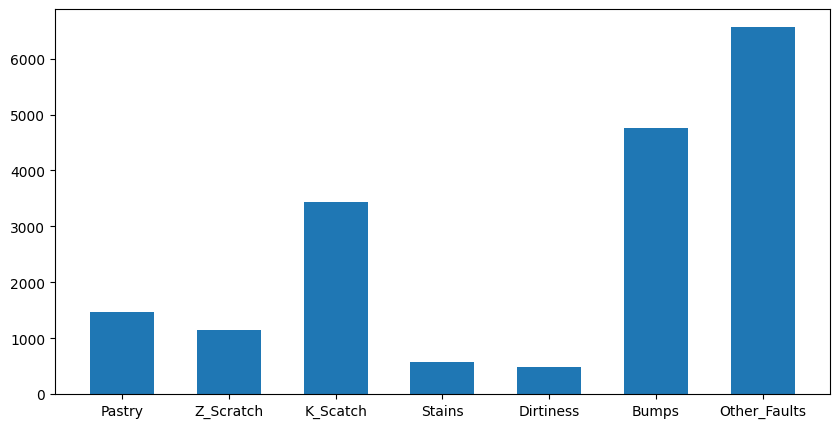

In [68]:
courses= []
values= []
for i in target_cols:
    courses.append(i)
    values.append(data_train[i].sum())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(courses, values, width = 0.6)
plt.show()

In [69]:
def feature_engineer(df):
    df = df.drop('id',axis=1)
    df['Width'] =  df['X_Maximum'] - df['X_Minimum']
    df['Height'] = df['Y_Maximum'] - df['Y_Minimum']
    df['Density'] = df['Pixels_Areas'] / (df['X_Perimeter'] + df['Y_Perimeter'])
    df['Diff_Luminosity'] = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity']
    return df

In [70]:
features = feature_engineer(data_train.copy()).drop(target_cols, axis = 1)
targets = pd.DataFrame()
targets['Target'] = np.argmax(data_train[target_cols].values, axis=1) + 1
targets = pd.concat([targets,data_train[target_cols]],axis = 1)
targets.loc[targets[target_cols].sum(axis=1) == 0, 'Target'] = 0
targets.drop(target_cols, inplace=True,axis =1)

In [71]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [72]:
targets = targets.values

In [73]:
search_space = {
                'learning_rate' : hp.uniform(label='learning_rate', low = 0.0001, high = 0.1),
                'n_estimators' : scope.int(hp.quniform(label='n_estimators', low = 100, high = 1000, q = 1)),
                'max_depth' : scope.int(hp.quniform(label='max_depth', low = 3, high = 25, q = 1)),
                'gamma' : hp.uniform(label='gamma', low = 0, high = 100),
                'subsample' : hp.uniform(label='subsample', low = 0, high = 1),
                'min_child_weight' : hp.uniform(label='min_child_weight', low = 0, high = 10),
                'reg_alpha': hp.uniform(label='reg_alpha', low = 0, high = 10),
                'reg_lambda': hp.uniform(label='reg_lambda', low = 0, high = 10),
                'tree_method' : hp.choice(label = 'tree_method',options = ['auto', 'exact', 'approx', 'hist'])
                }

In [74]:
def objective(params, X, y):
    xgb = XGBClassifier(n_jobs = -1,random_state = 42,objective='multi:softmax',**params)
    
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

    roc_auc = []
    for train_index, test_index in skf.split(X,y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        xgb.fit(X_train_fold, y_train_fold)
        y_pred_fold = xgb.predict_proba(X_test_fold)
        avg_roc_auc = roc_auc_score(data_train[target_cols].iloc[test_index], y_pred_fold[:, 1:], multi_class="ovr", average="macro")
    roc_auc.append(avg_roc_auc)

    return   {'loss': np.mean(roc_auc), 'params': params, 'status': STATUS_OK}   

In [79]:
trials = Trials()
best = fmin(
          # функция для оптимизации  
            fn=partial(objective, X=features, y=targets),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.rand.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=100,
          # куда сохранять историю поиска
            trials=trials,
          # progressbar
            show_progressbar=True)

100%|██████████████████████████████████████████████████████████| 100/100 [6:19:31<00:00, 227.72s/trial, best loss: 0.5]                                                                                           


In [80]:
trials.results

[{'loss': 0.8455755587041219,
  'params': {'gamma': 46.11207734321987,
   'learning_rate': 0.008339573588649094,
   'max_depth': 15,
   'min_child_weight': 7.758167744944696,
   'n_estimators': 158,
   'reg_alpha': 7.832523099985332,
   'reg_lambda': 3.200981210895044,
   'subsample': 0.5805845727017314,
   'tree_method': 'auto'},
  'status': 'ok'},
 {'loss': 0.8681206248483486,
  'params': {'gamma': 14.457793237753203,
   'learning_rate': 0.011155983209375001,
   'max_depth': 17,
   'min_child_weight': 6.62039407826891,
   'n_estimators': 278,
   'reg_alpha': 1.0435857842413243,
   'reg_lambda': 5.75346638317243,
   'subsample': 0.5721075545580139,
   'tree_method': 'hist'},
  'status': 'ok'},
 {'loss': 0.8759807667301001,
  'params': {'gamma': 3.5942740306027288,
   'learning_rate': 0.01011368432754389,
   'max_depth': 25,
   'min_child_weight': 0.1158891942934781,
   'n_estimators': 944,
   'reg_alpha': 5.2398401488065005,
   'reg_lambda': 1.364012025581538,
   'subsample': 0.176373

In [81]:
def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame 

    :hp_results: результаты hyperop
    :return: pandas DataFrame
    """ 

    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results.sort_values(by=['loss'], ascending=False, inplace=True)
    return results

In [82]:
res = df_results(trials.results)
res

,loss,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,tree_method
7,0.882922,4.687229,0.027759,20,5.713666,785,8.876544,4.434771,0.920629,exact
19,0.878212,2.883414,0.071387,12,8.613767,874,6.342585,2.151315,0.158849,hist
33,0.877505,5.284949,0.015156,14,0.986657,393,8.084595,6.198930,0.918179,auto
2,0.875981,3.594274,0.010114,25,0.115889,944,5.239840,1.364012,0.176373,auto
69,0.875219,12.960561,0.015786,17,6.472969,914,2.798255,4.727168,0.764781,auto
...,...,...,...,...,...,...,...,...,...,...
29,0.648177,41.144592,0.030255,4,7.799389,939,5.299933,5.185495,0.010237,exact
3,0.645495,38.774611,0.088569,15,3.905946,893,2.331236,2.280161,0.008080,exact
18,0.640490,99.325213,0.033089,21,7.189123,420,2.430493,8.001048,0.014603,auto
72,0.500000,82.405599,0.078457,4,2.244331,431,7.975750,3.385394,0.010664,exact


In [83]:
best_params = {
    'gamma' : 4.687229,
    'learning_rate' : 0.027759,
    'max_depth' : 20,
    'min_child_weight' : 5.713666,
    'n_estimators' : 785,
    'reg_alpha' : 8.876544,
    'reg_lambda' : 4.434771,
    'subsample' : 0.920629,
    'tree_method' : 'exact'
}

In [85]:
best_xgb = XGBClassifier(**best_params)
best_xgb.fit(features,targets)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.687229, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.027759,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=5.713666, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=785, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [87]:
features_test = feature_engineer(data_test.copy())
scope = MinMaxScaler()
features_test = scope.fit_transform(features_test)

In [88]:
targets_pred = best_xgb.predict_proba(features_test)

In [90]:
result = pd.DataFrame(data_test['id'].values,columns = ['id'])
prediction = pd.DataFrame(targets_pred[:,1:],columns = target_cols)
result = pd.concat([result,prediction],axis = 1)

In [92]:
result.to_csv('my_submission.csv', index=False)